In [19]:
import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
from qiskit import Aer
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable

import sys
sys.path.insert(0, '../../src/')
from neuralnetwork import *
from analysis import *
from utils import *

#%matplotlib notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Expressivity of QKN vs Classic NN

## Trajectory Length

In [20]:
theta = np.linspace(0, 2*np.pi, 1000)
theta = np.append(theta, theta[0:1]).reshape(-1,1)

x1 = np.pi*(np.cos(theta)+1)/2
x2 = np.pi*(np.sin(theta)+1)/2
x_qcn = np.hstack([x1, x2])
x_dnn = scaler(x_qcn, mode="standard")

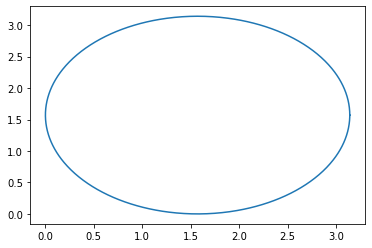

In [21]:
plt.plot(x_qcn[:,0], x_qcn[:,1])
plt.show()

## Random Initialization

### QCN

In [ ]:
np.random.seed(42)

network = sequential_qnn(n_qubits = 8*[4],
                         dim = [2] + 7*[4],
                         scale = 8*[[-np.pi, np.pi]],
                         encoder = Encoder(mode="x"),
                         ansatz = Ansatz(blocks=["entangle", "ry"], reps=2),
                         sampler = Parity(),
                         shots = 0)

tl = TrajectoryLength(network)
tl.fit(x_qcn)
saver(tl, data_path("tl_expressivity_width_4_reps_2"))

In [ ]:
np.random.seed(42)

network = sequential_qnn(n_qubits = 8*[5],
                         dim = [2] + 7*[5],
                         scale = 8*[[-np.pi, np.pi]],
                         encoder = Encoder(mode="x"),
                         ansatz = Ansatz(blocks=["entangle", "ry"], reps=2),
                         sampler = Parity(),
                         shots = 0)

tl = TrajectoryLength(network)
tl.fit(x_qcn)
saver(tl, data_path("tl_expressivity_width_5_reps_2"))

In [ ]:
np.random.seed(42)

network = sequential_qnn(n_qubits = 8*[6],
                         dim = [2] + 7*[6],
                         scale = 8*[[-np.pi, np.pi]],
                         encoder = Encoder(mode="x"),
                         ansatz = Ansatz(blocks=["entangle", "ry"], reps=2),
                         sampler = Parity(),
                         shots = 0)

tl = TrajectoryLength(network)
tl.fit(x_qcn)
saver(tl, data_path("tl_expressivity_width_6_reps_2"))

In [ ]:
np.random.seed(42)

network = sequential_qnn(n_qubits = 8*[7],
                         dim = [2] + 7*[7],
                         scale = 8*[[-np.pi, np.pi]],
                         encoder = Encoder(mode="x"),
                         ansatz = Ansatz(blocks=["entangle", "ry"], reps=2),
                         sampler = Parity(),
                         shots = 0)

tl = TrajectoryLength(network)
tl.fit(x_qcn)
saver(tl, data_path("tl_expressivity_width_7_reps_2"))

In [ ]:
np.random.seed(42)

network = sequential_qnn(n_qubits = 8*[8],
                         dim = [2] + 7*[8],
                         scale = 8*[[-np.pi, np.pi]],
                         encoder = Encoder(mode="x"),
                         ansatz = Ansatz(blocks=["entangle", "ry"], reps=2),
                         sampler = Parity(),
                         shots = 0)

tl = TrajectoryLength(network)
tl.fit(x_qcn)
saver(tl, data_path("tl_expressivity_width_8_reps_2"))

### DNN

In [ ]:
network = sequential_dnn(dim=[2] + 7*[10])

tl = TrajectoryLength(network)
tl.fit(x_dnn)

network.predict(x_dnn, verbose=True)
saver(tl, data_path("tl_expressivity_dnn"))

## Training

In [22]:
np.random.seed(42)

n = 12
x = np.linspace(0, 1, n)
x = generate_meshgrid([x,x])

mean1 = np.array([[0.2, 0.8]])
var1 = np.array([[0.01, 0], [0, 0.01]])

mean2 = np.array([[0.5, 0.8]])
var2 = np.array([[0.01, 0], [0, 0.01]])

mean3 = np.array([[0.8, 0.8]])
var3 = np.array([[0.01, 0], [0, 0.01]])

mean4 = np.array([[0.2, 0.5]])
var4 = np.array([[0.01, 0], [0, 0.01]])

mean5 = np.array([[0.5, 0.5]])
var5 = np.array([[0.01, 0], [0, 0.01]])

mean6 = np.array([[0.8, 0.5]])
var6 = np.array([[0.01, 0], [0, 0.01]])

mean7 = np.array([[0.2, 0.2]])
var7 = np.array([[0.01, 0], [0, 0.01]])

mean8 = np.array([[0.5, 0.2]])
var8 = np.array([[0.01, 0], [0, 0.01]])

mean9 = np.array([[0.8, 0.2]])
var9 = np.array([[0.01, 0], [0, 0.01]])


y = gaussian(x, mean1, var1) - gaussian(x, mean2, var2) + gaussian(x, mean3, var3) - gaussian(x, mean4, var4) +\
gaussian(x, mean5, var5) - gaussian(x, mean6, var6) + gaussian(x, mean7, var7) - gaussian(x, mean8, var8) +\
gaussian(x, mean9, var9)


x_train_qcn = scaler(x, a=-np.pi/2, b=np.pi/2)
x_train_dnn = scaler(x, mode="standard")
y = scaler(y, a=0, b=1)

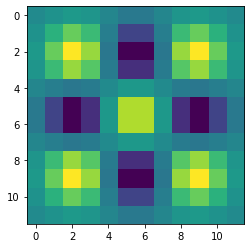

In [23]:
plt.imshow(y.reshape(n,n))
plt.show()

### QCN

### 5 Qubits

In [24]:
np.random.seed(42)
network = sequential_qnn(n_qubits = [5, 5, 5, 5],
                         dim = [2, 5, 5, 5, 1] ,
                         scale = 3*[[-np.pi, np.pi]] + [[0,1]],
                         encoder = Encoder(mode="x"),
                         ansatz = Ansatz(blocks=["entangle", "ry"], reps=2),
                         sampler = Parity(),
                         shots = 0,
                         optimizer=Adam(lr=0.1))

In [25]:
tl = TrajectoryLength(network)
tl.fit(x_qcn)
saver(tl, data_path("tl_expressivity_qubit_5_epochs_0"))

In [26]:
network.train(x_train_qcn, y, epochs = 10, verbose=True)

tl = TrajectoryLength(network)
tl.fit(x_qcn)
saver(tl, data_path("tl_expressivity_qubit_5_epochs_10"))

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 0, loss: 0.10753750855339678
epoch: 1, loss: 0.05469373487535791
epoch: 2, loss: 0.06194648418692619
epoch: 3, loss: 0.05358460329241951
epoch: 4, loss: 0.05378873103479949
epoch: 5, loss: 0.05388694821995833
epoch: 6, loss: 0.05364019949536528
epoch: 7, loss: 0.05283920363719211
epoch: 8, loss: 0.052077703096661675
epoch: 9, loss: 0.05157267528178281


In [27]:
network.train(x_train_qcn, y, epochs = 10, verbose=True)

tl = TrajectoryLength(network)
tl.fit(x_qcn)
saver(tl, data_path("tl_expressivity_qubit_5_epochs_20"))

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 0, loss: 0.05060743389569197
epoch: 1, loss: 0.0499388478173374
epoch: 2, loss: 0.04799817186332259
epoch: 3, loss: 0.045554830316214844
epoch: 4, loss: 0.04091426128932548
epoch: 5, loss: 0.03847438209158517
epoch: 6, loss: 0.03564557133516782
epoch: 7, loss: 0.03814066640740307
epoch: 8, loss: 0.028661446243289885
epoch: 9, loss: 0.02914614204075895


In [28]:
network.train(x_train_qcn, y, epochs = 10, verbose=True)

tl = TrajectoryLength(network)
tl.fit(x_qcn)
saver(tl, data_path("tl_expressivity_qubit_5_epochs_30"))

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 0, loss: 0.03817022812221903
epoch: 1, loss: 0.02626776343782878
epoch: 2, loss: 0.030543742422384595
epoch: 3, loss: 0.0248334215038493
epoch: 4, loss: 0.030885032494114475
epoch: 5, loss: 0.024074534095583706
epoch: 6, loss: 0.025654146420673207
epoch: 7, loss: 0.021622691826322572
epoch: 8, loss: 0.023409098374442296
epoch: 9, loss: 0.019499462888387675


In [29]:
network.train(x_train_qcn, y, epochs = 10, verbose=True)

tl = TrajectoryLength(network)
tl.fit(x_qcn)
saver(tl, data_path("tl_expressivity_qubit_5_epochs_40"))

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 0, loss: 0.019259825996106778
epoch: 1, loss: 0.01545549785570197
epoch: 2, loss: 0.015872797803214194
epoch: 3, loss: 0.012221755331321011
epoch: 4, loss: 0.012623849971247873
epoch: 5, loss: 0.010095911990899495
epoch: 6, loss: 0.010732578006679353
epoch: 7, loss: 0.009253446980001745
epoch: 8, loss: 0.008777549505998353
epoch: 9, loss: 0.008229580223710042


### 6 Qubits

In [30]:
np.random.seed(42)
network = sequential_qnn(n_qubits = [6, 6, 6, 6],
                         dim = [2, 6, 6, 6, 1] ,
                         scale = 3*[[-np.pi, np.pi]] + [[0,1]],
                         encoder = Encoder(mode="x"),
                         ansatz = Ansatz(blocks=["entangle", "ry"], reps=2),
                         sampler = Parity(),
                         shots = 0,
                         optimizer=Adam(lr=0.1))

In [31]:
tl = TrajectoryLength(network)
tl.fit(x_qcn)
saver(tl, data_path("tl_expressivity_qubit_6_epochs_0"))

In [32]:
network.train(x_train_qcn, y, epochs = 10, verbose=True)

tl = TrajectoryLength(network)
tl.fit(x_qcn)
saver(tl, data_path("tl_expressivity_qubit_6_epochs_10"))

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 0, loss: 0.08630832338085878
epoch: 1, loss: 0.05709119811722255
epoch: 2, loss: 0.05400108420612014
epoch: 3, loss: 0.053064641330191814
epoch: 4, loss: 0.05272043035916593
epoch: 5, loss: 0.05242343407293984
epoch: 6, loss: 0.05192663486242562
epoch: 7, loss: 0.05143327711198853
epoch: 8, loss: 0.05056431601586434
epoch: 9, loss: 0.04848666015700506


In [33]:
network.train(x_train_qcn, y, epochs = 10, verbose=True)

tl = TrajectoryLength(network)
tl.fit(x_qcn)
saver(tl, data_path("tl_expressivity_qubit_6_epochs_20"))

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 0, loss: 0.046085691928983596
epoch: 1, loss: 0.04216105602885562
epoch: 2, loss: 0.03933682122375527
epoch: 3, loss: 0.033096270329572755
epoch: 4, loss: 0.029905018560120948
epoch: 5, loss: 0.025008015753748412
epoch: 6, loss: 0.023873648413097626
epoch: 7, loss: 0.01912223392860887
epoch: 8, loss: 0.018102093622113735
epoch: 9, loss: 0.016987040080188906


In [34]:
network.train(x_train_qcn, y, epochs = 10, verbose=True)

l = TrajectoryLength(network)
tl.fit(x_qcn)
saver(tl, data_path("tl_expressivity_qubit_6_epochs_30"))

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 0, loss: 0.014431676708826693
epoch: 1, loss: 0.015146095178957958
epoch: 2, loss: 0.01958366631535198
epoch: 3, loss: 0.023683495859406364
epoch: 4, loss: 0.013991335944048496
epoch: 5, loss: 0.023104201418871942
epoch: 6, loss: 0.01735866745447305
epoch: 7, loss: 0.015321837058061338
epoch: 8, loss: 0.015234180419374506
epoch: 9, loss: 0.016139233828695164


In [35]:
network.train(x_train_qcn, y, epochs = 10, verbose=True)

tl = TrajectoryLength(network)
tl.fit(x_qcn)
saver(tl, data_path("tl_expressivity_qubit_6_epochs_40"))

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 0, loss: 0.010671422827442977
epoch: 1, loss: 0.015154134450343828
epoch: 2, loss: 0.0105531579237618
epoch: 3, loss: 0.011381035644690236
epoch: 4, loss: 0.009408233004157955
epoch: 5, loss: 0.010199279856411392
epoch: 6, loss: 0.007658636808282448
epoch: 7, loss: 0.00994797983224541
epoch: 8, loss: 0.0064721261233679035
epoch: 9, loss: 0.008191681451436804


In [36]:
network.train(x_train_qcn, y, epochs = 10, verbose=True)

tl = TrajectoryLength(network)
tl.fit(x_qcn)
saver(tl, data_path("tl_expressivity_qubit_6_epochs_50"))

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 0, loss: 0.006783865885317551
epoch: 1, loss: 0.006475650362592383
epoch: 2, loss: 0.0054668203653854865
epoch: 3, loss: 0.00683297434565143
epoch: 4, loss: 0.004526863409948825
epoch: 5, loss: 0.005537339670382462
epoch: 6, loss: 0.00436582598421782
epoch: 7, loss: 0.004155034803544259
epoch: 8, loss: 0.00417155589913147
epoch: 9, loss: 0.003284353725829367


In [37]:
network.train(x_train_qcn, y, epochs = 10, verbose=True)

tl = TrajectoryLength(network)
tl.fit(x_qcn)
saver(tl, data_path("tl_expressivity_qubit_6_epochs_60"))

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 0, loss: 0.0038453478504707752
epoch: 1, loss: 0.00296567900801277
epoch: 2, loss: 0.003108908157427461
epoch: 3, loss: 0.0030866851477173735
epoch: 4, loss: 0.0023864519975515803
epoch: 5, loss: 0.002524318273437375
epoch: 6, loss: 0.002691676825104915
epoch: 7, loss: 0.002311849065869853
epoch: 8, loss: 0.0017002807361710154
epoch: 9, loss: 0.002058991681969347


In [38]:
network.train(x_train_qcn, y, epochs = 10, verbose=True)

tl = TrajectoryLength(network)
tl.fit(x_qcn)
saver(tl, data_path("tl_expressivity_qubit_6_epochs_70"))

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 0, loss: 0.002356001331843218
epoch: 1, loss: 0.0022743652006216486
epoch: 2, loss: 0.002186556486717349
epoch: 3, loss: 0.0019316922780747278
epoch: 4, loss: 0.0015763981769627204
epoch: 5, loss: 0.0015174827470473451
epoch: 6, loss: 0.0013429803637499756
epoch: 7, loss: 0.0013554341176107917
epoch: 8, loss: 0.0013081970214949249
epoch: 9, loss: 0.001724320138235086


In [39]:
network.train(x_train_qcn, y, epochs = 10, verbose=True)

tl = TrajectoryLength(network)
tl.fit(x_qcn)
saver(tl, data_path("tl_expressivity_qubit_6_epochs_80"))

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 0, loss: 0.0034581825898862164
epoch: 1, loss: 0.009492497513711472
epoch: 2, loss: 0.009415565467820372
epoch: 3, loss: 0.0018026710178850008
epoch: 4, loss: 0.005899212312531957
epoch: 5, loss: 0.0025240704981994012
epoch: 6, loss: 0.00393041844128431
epoch: 7, loss: 0.0022490506657733347
epoch: 8, loss: 0.0033260044921717778
epoch: 9, loss: 0.0023106501794766966


### DNN

#### 8 Nodes

In [63]:
np.random.seed(42)
network = sequential_dnn(dim=[2, 8, 8, 8, 1],
                         optimizer=Adam(lr=0.1))

In [64]:
tl = TrajectoryLength(network)
tl.fit(x_dnn)
saver(tl, data_path("tl_expressivity_epochs_0_dnn"))

In [65]:
network.train(x_train_dnn, y, epochs=66)

tl = TrajectoryLength(network)
tl.fit(x_dnn)
saver(tl, data_path("tl_expressivity_epochs_66_dnn"))

In [66]:
network.train(x_train_dnn, y, epochs=46)

tl = TrajectoryLength(network)
tl.fit(x_dnn)
saver(tl, data_path("tl_expressivity_epochs_112_dnn"))

In [67]:
network.train(x_train_dnn, y, epochs=45)

tl = TrajectoryLength(network)
tl.fit(x_dnn)
saver(tl, data_path("tl_expressivity_epochs_157_dnn"))

In [68]:
network.train(x_train_dnn, y, epochs=376)

tl = TrajectoryLength(network)
tl.fit(x_dnn)
saver(tl, data_path("tl_expressivity_epochs_533_dnn"))

#### 9 Nodes

In [78]:
np.random.seed(42)
network = sequential_dnn(dim=[2, 9, 9, 9, 1],
                         optimizer=Adam(lr=0.1))

In [79]:
tl = TrajectoryLength(network)
tl.fit(x_dnn)
saver(tl, data_path("tl_expressivity_epochs_0_dnn_9_nodes"))

In [80]:
network.train(x_train_dnn, y, epochs=72, verbose=True)

tl = TrajectoryLength(network)
tl.fit(x_dnn)
saver(tl, data_path("tl_expressivity_epochs_72_dnn_9_nodes"))

  0%|          | 0/72 [00:00<?, ?it/s]

epoch: 0, loss: 0.05993721742985571
epoch: 1, loss: 0.06501206684502787
epoch: 2, loss: 0.057736839905299174
epoch: 3, loss: 0.05362294283117229
epoch: 4, loss: 0.056239575025647665
epoch: 5, loss: 0.05762808103905383
epoch: 6, loss: 0.05604302062088107
epoch: 7, loss: 0.05409676083594415
epoch: 8, loss: 0.05365388151967762
epoch: 9, loss: 0.054486433333276046
epoch: 10, loss: 0.05527965839276099
epoch: 11, loss: 0.0552164336945919
epoch: 12, loss: 0.054513135817509856
epoch: 13, loss: 0.05383487949070592
epoch: 14, loss: 0.05360239664651471
epoch: 15, loss: 0.05378686632939146
epoch: 16, loss: 0.05410655802433405
epoch: 17, loss: 0.05429661325692822
epoch: 18, loss: 0.05425610105449975
epoch: 19, loss: 0.054046311856170294
epoch: 20, loss: 0.053801986402693944
epoch: 21, loss: 0.053637975343443015
epoch: 22, loss: 0.0536002029182141
epoch: 23, loss: 0.053664555171920314
epoch: 24, loss: 0.053766052793128835
epoch: 25, loss: 0.05383847568383087
epoch: 26, loss: 0.05384580966512607
epoc

In [81]:
network.train(x_train_dnn, y, epochs=115, verbose=True)

tl = TrajectoryLength(network)
tl.fit(x_dnn)
saver(tl, data_path("tl_expressivity_epochs_187_dnn_9_nodes"))

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 0, loss: 0.04835065558742931
epoch: 1, loss: 0.047648065482059784
epoch: 2, loss: 0.046838722461521175
epoch: 3, loss: 0.045915404311156184
epoch: 4, loss: 0.0448122834228092
epoch: 5, loss: 0.04360102042017292
epoch: 6, loss: 0.0424460061563434
epoch: 7, loss: 0.04145604233582537
epoch: 8, loss: 0.040690470989853046
epoch: 9, loss: 0.04012133576847207
epoch: 10, loss: 0.03967223588187924
epoch: 11, loss: 0.039362194985538154
epoch: 12, loss: 0.039164157462300744
epoch: 13, loss: 0.03905209539349275
epoch: 14, loss: 0.03893987082603199
epoch: 15, loss: 0.0387869904048537
epoch: 16, loss: 0.03863957436801924
epoch: 17, loss: 0.03851674162596329
epoch: 18, loss: 0.03837429766268913
epoch: 19, loss: 0.03816450378490951
epoch: 20, loss: 0.03788748813144293
epoch: 21, loss: 0.037702479599868825
epoch: 22, loss: 0.03758215115795988
epoch: 23, loss: 0.03747242288565068
epoch: 24, loss: 0.03753865856183555
epoch: 25, loss: 0.03760966109744615
epoch: 26, loss: 0.03713428109155902
epoch: 

In [82]:
network.train(x_train_dnn, y, epochs=9, verbose=True)

tl = TrajectoryLength(network)
tl.fit(x_dnn)
saver(tl, data_path("tl_expressivity_epochs_196_dnn_9_nodes"))

  0%|          | 0/9 [00:00<?, ?it/s]

epoch: 0, loss: 0.016971508869442112
epoch: 1, loss: 0.016852185424304614
epoch: 2, loss: 0.01671009276343708
epoch: 3, loss: 0.01659975034729182
epoch: 4, loss: 0.016477779616904054
epoch: 5, loss: 0.016360155515457355
epoch: 6, loss: 0.016258201841426456
epoch: 7, loss: 0.01613345151848344
epoch: 8, loss: 0.016015165338110857


In [83]:
network.train(x_train_dnn, y, epochs=245, verbose=True)

tl = TrajectoryLength(network)
tl.fit(x_dnn)
saver(tl, data_path("tl_expressivity_epochs_441_dnn_9_nodes"))

  0%|          | 0/245 [00:00<?, ?it/s]

epoch: 0, loss: 0.01592050171967663
epoch: 1, loss: 0.015824066311189083
epoch: 2, loss: 0.015745392335414235
epoch: 3, loss: 0.01567390063337755
epoch: 4, loss: 0.015580518210839575
epoch: 5, loss: 0.015494992230975453
epoch: 6, loss: 0.015411305804976398
epoch: 7, loss: 0.0153178624510629
epoch: 8, loss: 0.015227624792476444
epoch: 9, loss: 0.015135465866034167
epoch: 10, loss: 0.015044348446712381
epoch: 11, loss: 0.014961815589698176
epoch: 12, loss: 0.014888525138438278
epoch: 13, loss: 0.014812475767282483
epoch: 14, loss: 0.01473491787411738
epoch: 15, loss: 0.014655931889841649
epoch: 16, loss: 0.01457187332685357
epoch: 17, loss: 0.014488504058871813
epoch: 18, loss: 0.014406922898464378
epoch: 19, loss: 0.014326799034152701
epoch: 20, loss: 0.01424658936602123
epoch: 21, loss: 0.014169941676793918
epoch: 22, loss: 0.014095889992566779
epoch: 23, loss: 0.014022477051928963
epoch: 24, loss: 0.01394902681657491
epoch: 25, loss: 0.013878063030696528
epoch: 26, loss: 0.01381051978